<a href="https://colab.research.google.com/github/Pavel184/Machine_vision/blob/Homework_lesson_6/Homework_lesson_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение эмбеддингов (Metric Learning)
Данные, необходимые для этого модуля:
* symbol_a1.png
* symbol_a2.png
* symbol_b1.png

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [4]:
tfds.disable_progress_bar()
(train_ds), ds_info = tfds.load(
    'LFW', 
    as_supervised=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete1ER6J0/lfw-train.tfrecord
Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
train_ds = train_ds.get('train')

## Визуализация датасета LFW

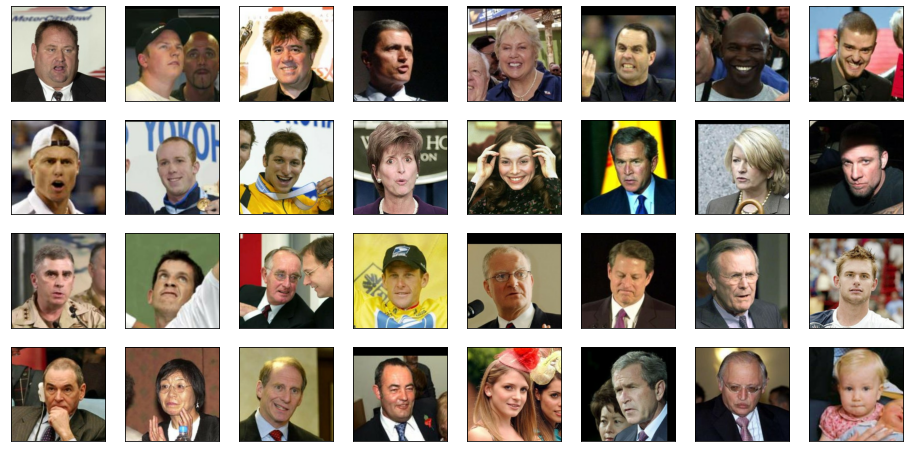

In [7]:
some_samples = [x[1] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели CNN

In [8]:
EMB_SIZE = 256

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [9]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return z, tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [10]:
BATCH_SIZE = 64
NUM_EPOCHS = 60
def prepare(label, img):
    img = tf.cast(img, tf.float32)/127. - 1.
    return img, label

def prep_test(img, label):
    return img

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

## Подготовка к обучению

In [11]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [12]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        z, loss_value = contastive_loss(embs, labels)
        
       
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if loss_value > 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

Streaming output truncated to the last 5000 lines.
[857] Loss: 11.663538932800293
[859] Loss: 0.0025218953378498554
[860] Loss: 0.019902804866433144
[861] Loss: 0.8402252197265625
[862] Loss: 0.12639114260673523
[863] Loss: 0.037456825375556946
[864] Loss: 0.6425886154174805
[865] Loss: 0.15773674845695496
[866] Loss: 0.0015984268393367529
[867] Loss: 0.08535535633563995
[869] Loss: 13.860980033874512
[870] Loss: 0.10797448456287384
[873] Loss: 0.1727549433708191
[874] Loss: 0.24168483912944794
[876] Loss: 0.06050732359290123
[878] Loss: 0.03303154930472374
[879] Loss: 0.0025957110337913036
[880] Loss: 3.5217227935791016
[881] Loss: 0.03161271661520004
[883] Loss: 0.2919679880142212
[884] Loss: 0.04920605570077896
[885] Loss: 0.08736677467823029
[886] Loss: 0.06621558964252472
[887] Loss: 0.33100655674934387
[888] Loss: 0.015034634619951248
[889] Loss: 0.19196712970733643
[891] Loss: 0.1186632513999939
[893] Loss: 47.418609619140625
[896] Loss: 0.06702607870101929
[897] Loss: 0.2861446

## Вычисление расстояний между эмбеддингами

In [13]:
INP_SIZE = 250

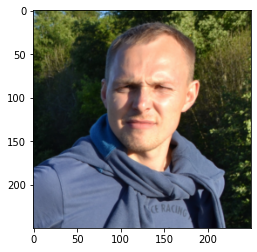

In [14]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)



a_1 = imageio.imread('a_1.jpg', pilmode="RGB")
a_1 = prepare_image(a_1)
plt.imshow(a_1)

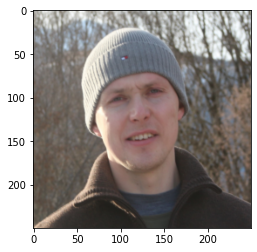

In [15]:
a_2 = imageio.imread('a_2.jpg', pilmode="RGB")
a_2 = prepare_image(a_2)
plt.imshow(a_2)

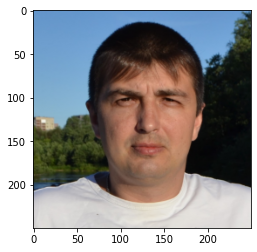

In [16]:
b_1 = imageio.imread('b_1.jpg', pilmode="RGB")
b_1 = prepare_image(b_1)
plt.imshow(b_1)

In [17]:
new_embs = model(np.stack((a_1, a_2, b_1), axis=0))

In [18]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  190.48492804550182
A2 <-> B1:  215.55430906444437
A1 <-> B1:  209.3697667256426


Вывод: На примере загруженных фотографий видно, что расстояние между эмбеддингами фотографий одного человека меньше, чем расстояние между эмбеддингами разных людей. Но при этом разница расстояний не столь велика как хотелось бы. Скорее всего это из за довольно простой функции потерь и из-за того, что мы не определяли положения лиц и фон фотографии так же повлиял на эмбеддинг.